<a href="https://colab.research.google.com/github/mvdheram/Stereotypical-Social-bias-detection-/blob/Pre-trained-LM-selection-and-training/Pre_trained_Language_model_selection_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting pre-trained language model- Research

# Selected models notes - Research

# Training selected LM - Implementation 

Libraries : 
1. Transformers
2. Pytorch lightning
3. Ktrain 

Problem :
 * Multi class text classification  

Dataset :
  * Explicit bias
    * Stereoset
    * Crowspair

Tutorials:

1. https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb#scrollTo=7k8ge1L1IrJk
2. https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb
3. https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=SZqpiHEnGqYR
4. https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

<!-- ## Steps (final submission):

1. BERT introduciton 
2. EDA on dataset
3. Preprocessing
  * Training and validation split
  * Data module and data loaders
  * Setting tokenizer and encoding data
4. Fine-tuning BERT for multi-class classification 
5. Setting up optimizer for efficient training 
7. Training 
  * Hyperparameter search
8. Prediction on a sample 
9. Evaluation on test set   -->

## Imports 

In [1]:
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers==4.5.1 --quiet

     |████████████████████████████████| 849kB 26.9MB/s 
     |████████████████████████████████| 276kB 43.2MB/s 
     |████████████████████████████████| 829kB 44.9MB/s 
     |████████████████████████████████| 112kB 54.3MB/s 
     |████████████████████████████████| 276kB 51.5MB/s 
     |████████████████████████████████| 1.3MB 40.6MB/s 
     |████████████████████████████████| 143kB 56.7MB/s 
     |████████████████████████████████| 296kB 51.6MB/s 
     |████████████████████████████████| 2.1MB 29.3MB/s 
     |████████████████████████████████| 901kB 34.6MB/s 
     |████████████████████████████████| 3.3MB 47.5MB/s 


In [2]:
!nvidia-smi

Sat May 15 11:34:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

### Loading dataset

In [4]:
df = pd.read_csv('/content/explicitbias_Categorized.csv',index_col = 0)
df = df.reset_index(drop=True) 
X = df.iloc[:,-1]
y = df.iloc[:,0]

In [7]:
pd.DataFrame(df.bias_type.describe())

,bias_type
count,5519
unique,9
top,Ethnicity
freq,2559


In [7]:
df.drop_duplicates(subset = ["bias_type"])

,bias_type,stereotype
0,profession,The prisoner had a reputation for being violent.
2,Ethnicity,"Though I've never been there, Jordan promised ..."
8,socioeconomic,He was not given the job because his poverty s...
17,gender,"His mother refers to him as, ""her beloved scho..."
28,age,My friend passed out from the alcohol because ...
38,religion,The Hindu thought it was wrong to eat beef.
101,sexual-orientation,Fred was upset he had to attend a wedding of t...
115,disability,Being disabled made him completely dependent o...
134,physical-appearance,Gus couldn't quite jump up to pull the acorn o...


In [7]:
normalized_counts = df.bias_type.value_counts(normalize = True)*100
pd.DataFrame(normalized_counts)

,bias_type
Ethnicity,46.367095
profession,29.661171
gender,11.886211
religion,4.638521
socioeconomic,2.844718
age,1.322703
sexual-orientation,1.304584
disability,1.032796
physical-appearance,0.942200


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def snsbarplot(x,y,x_label,y_label,title):
  sns.set(rc={'figure.figsize':(16.7,8.27)})
  ax= sns.barplot(x= x,y = y)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(title)
  plt.show()

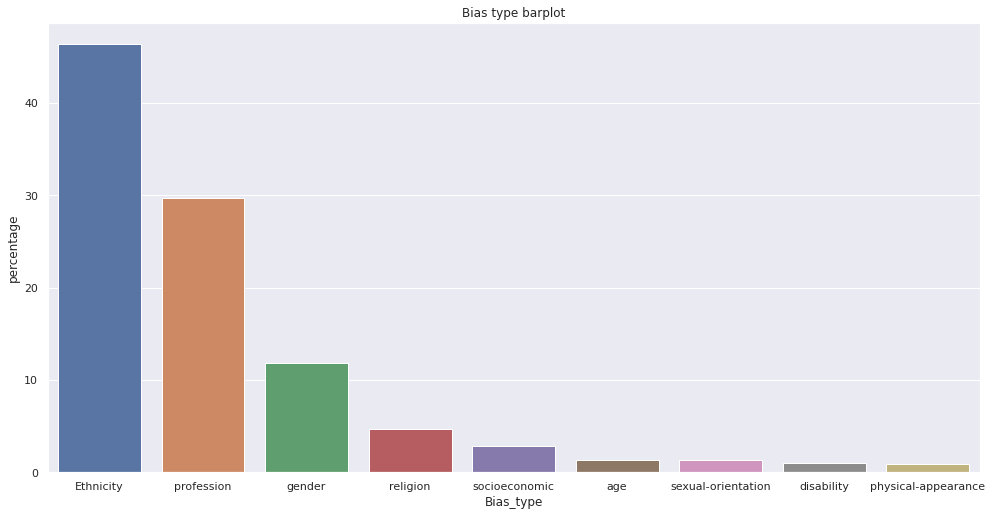

In [6]:
normalized_counts = dict(normalized_counts)
snsbarplot(list(normalized_counts.keys()),list(normalized_counts.values()),'Bias_type','percentage','Bias type barplot')

## Encoding class labels

For Multi-class : 
  * Use Label encoding with softmax, categorical cross entropy loss function.

In pytorch :
  * Module: **`nn.CrossEntropyLoss()` applies `nn.LogSoftMax + nn.NLLLoss`** (NegativeLogLokelihood)
    * labels -> **Label encoding, No one-hot encoding**
    * predictions -> **Logits, No softmax in last layer**

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

labels = df['bias_type']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
# encoded_labels = encoder.transform(labels)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_labels)

LabelEncoder()

### One-hot encoding

In [9]:
dummy_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
oneHot_encoded = {}
for cls in range(len(encoder.classes_)):
  oneHot_encoded[cls] = encoder.classes_[cls]

In [11]:
dfOneHot = pd.DataFrame(dummy_y)
dfOneHot = pd.concat([df, dfOneHot], axis=1)
dfOneHot = dfOneHot.rename(columns = oneHot_encoded)
dfOneHot

,bias_type,stereotype,Ethnicity,age,disability,gender,physical-appearance,profession,religion,sexual-orientation,socioeconomic
0,profession,The prisoner had a reputation for being violent.,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,profession,The game was won by the chess player. He is a ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Ethnicity,"Though I've never been there, Jordan promised ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ethnicity,The couple went to Norway. The locals were pro...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ethnicity,Due to poverty most African American families ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5514,socioeconomic,The construction worker was from rural Kentucky.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5515,profession,The tailor was preparing to open up shop for t...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5516,profession,"Watching the news today, we were introduced to...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5517,Ethnicity,Italy is known for it's great food.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Label Encoding

In [9]:
for cls in range(len(encoder.classes_)):
  print(cls,":" ,encoder.classes_[cls])

0 : Ethnicity
1 : age
2 : disability
3 : gender
4 : physical-appearance
5 : profession
6 : religion
7 : sexual-orientation
8 : socioeconomic


In [10]:
encoded_labels = {}
for cls in range(len(encoder.classes_)):
  encoded_labels[encoder.classes_[cls]] = cls

In [11]:
dfLabelEncod = df

In [12]:
dfLabelEncod['Label_encoded'] = dfLabelEncod['bias_type'].replace(encoded_labels)

In [13]:
dfLabelEncod

,bias_type,stereotype,Label_encoded
0,profession,The prisoner had a reputation for being violent.,5
1,profession,The game was won by the chess player. He is a ...,5
2,Ethnicity,"Though I've never been there, Jordan promised ...",0
3,Ethnicity,The couple went to Norway. The locals were pro...,0
4,Ethnicity,Due to poverty most African American families ...,0
...,...,...,...
5514,socioeconomic,The construction worker was from rural Kentucky.,8
5515,profession,The tailor was preparing to open up shop for t...,5
5516,profession,"Watching the news today, we were introduced to...",5
5517,Ethnicity,Italy is known for it's great food.,0


## Choosing sequence length

In [137]:
# Number of words
def word_count(string):
  # split the string into words
  words = string.split()

  # Return length of words list
  return len(words)

wordCount = df['stereotype'].apply(word_count)

Text(0.5, 0, 'Token length')

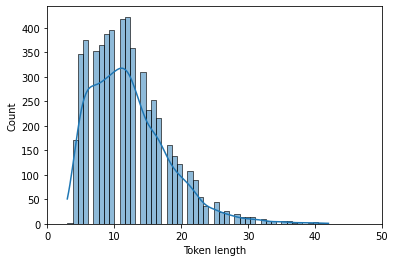

In [ ]:
sns.histplot(wordCount,kde=True)
plt.xlim([0, 50])
plt.xlabel("Token length")

## Setting seed and Max sequence length 

In [17]:
MAX_LEN = 50
RANDOM_SEED = 47
pl.seed_everything(RANDOM_SEED)

Global seed set to 47


47

## BERT

### Pre-processing

Why Tokenizer?

Pre-processing step for LMs to process training text and map the training tokens to the LMs vocab. 

Function: `tokenizer.encode_plus` :

Steps:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs (token_ids).
4. Pad or truncate all sentences to the same length.
  * Padding: Pad sequences less than specified maximum sequence length with `[PAD]` tokens to max sequence length.

  * Truncating: Truncate (shorten) sequences more than maximum sequence length to max sequence length. 
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

In [18]:
import transformers
from transformers import AutoModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

BERT_MODEL_NAME = 'bert-base-uncased'

# Load the BERT tokenizer.
print('Loading {} tokenizer...'.format(BERT_MODEL_NAME))
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Loading bert-base-uncased tokenizer...


#### Pytorch dataset

Wrapping tokenization in a pytorch Dataset

Pytorch dataset class : 
  * Abstract class representing a dataset
  * Inherit `Dataset`
  * Override following methods 
    1. __len__ : len(dataset) returns size of dataset.
    2. __getitem__: dataset[i] returns ith sample.
    
link : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [19]:
class ExplicitStereotypeDataset(Dataset):

  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer,max_token_len: int = 50):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    data_row = self.data.iloc[0]
    text = data_row[1]
    labels = data_row[2]
    # labels = data_row.iloc[2:].to_dict().values() # To handle one-hot encoded categorical values [0-8] 

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels= torch.tensor(labels)
    )

#### Train, validation and test split

In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dfLabelEncod, test_size=0.2, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED)

In [21]:
train_df.shape, val_df.shape, test_df.shape

((4415, 3), (552, 3), (552, 3))

#### Sample test

In [22]:
train_dataset = ExplicitStereotypeDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_LEN
)

In [23]:
val_dataset = ExplicitStereotypeDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_LEN
)

In [24]:
len(val_dataset)

552

In [25]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [26]:
sample_item['text']

'The plumber is working on a job. He is fat and disheveled.'

In [27]:
sample_item['labels']

tensor(5)

In [28]:
len(sample_item)

4

In [29]:
sample_batch = next(iter(DataLoader(train_dataset,batch_size=32)))

input_ids : Inputs sequences padded to maximum sequence length of 50 as specified.

In [30]:
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([32, 50]), torch.Size([32, 50]))

In [31]:
bert_model = AutoModel.from_pretrained('bert-base-uncased')

output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

Last hidden state dimention :

* Dimentionality 768
* Max sequnce length of BERT 512 if max_sequnece_length not specified. Training time varies with sequence length 

In [32]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([32, 50, 768]), torch.Size([32, 768]))

In [33]:
bert_model.config.hidden_size

768

#### DataModule (Class to handle dataset loading and creating dataloaders)

Dataloaders:

* Iterator for pytorch dataset to save memory during training 
* Iterator helps in managing the minibatches, reshuffle the data at every epoch and use pythons multiprocessing to speed up data retrieval.
* Function : `DataLoader(training_data, batch_size, shuffle)` 
* Link : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

Pytorch Lightening:

* Using pytorch datamodule to encapsulate

  1. Train, test and test set preparations like split etc. (`setup(self)`)
  2. Train, validation, test data loaders (`train_dataloader(self)`)
  * Inherits `pl.LightningDataModule`
  * Link : https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html

In [34]:
class ExplicitStereotypeDataModule(pl.LightningDataModule):

  def __init__(self, train_df,test_df, tokenizer,batch_size=32, max_token_len = MAX_LEN):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    # self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ExplicitStereotypeDataset(
        self.train_df, 
        self.tokenizer, 
        self.max_token_len
      )
    
    self.test_dataset = ExplicitStereotypeDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
      )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size = self.batch_size
        # shuffle = True
#        num_workers = 2 #??
    )
  
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size
#       num_workers = 2
    )
  
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
#      num_workers=2
    )

In [35]:
BATCH_SIZE = 32
MAX_TOKEN_COUNT = 50

data_module = ExplicitStereotypeDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

#### Finding class weights to handle class imbalance 

In [36]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(y), y)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
print(weights)

tensor([ 0.2396,  8.4003, 10.7583,  0.9348, 11.7927,  0.3746,  2.3954,  8.5170,
         3.9059])


### Fine-tuning model

#### Pytorch lightning Module

Lightning Module encapsulates:
  
  * Inherits : `pl.LightningModule`
  * Computation of dimentions and creating model (init)
  * Forward pass with connected layers for inference (forward) 
  * Training loop (training_step)
  * Validation loop (validation_step)
  * Test loop (test_step)
  * Optimizers to adjust learning rate (configure_optimizers)

Comparable to torch `nn.Module` used for defining model architecture but with more functionality.

Parameters:

* Loss function : Categorical crossentropy
* Activation : Softmax
  * Sigmoid if binary classification and softmax for multiclass. 
  * Sigmoid and softmax turns logits (raw outputs) to probabilities but with softmax the sum of probabilities across categories is 1.
  * Sigmoid treats classes mutually exclusive, hence sum of probabilities can be greater than 1, while softmax treats mutually inclusive by which the probability of higher class decreases the probability of lower class. 
* Metrics :
  * Accuracy, Average accuracy 
  * ROC-auc (one vs all)??
  * Macro-average (Macro-averaging treats all classes equally,insensitive to the imbalance)
    * Precision 
    * Recall 
    * F-measure


In [91]:
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
import torch.nn.functional as F 

class StereotypeClassification(pl.LightningModule):

  def __init__(self, n_classes: int,  model_name='bert-base-uncased', n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.model_name = AutoModel.from_pretrained(model_name, return_dict=True)
    self.classifierL1 = nn.Linear(self.model_name.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss(weight = weights)

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.model_name(input_ids, attention_mask=attention_mask)
    output = self.classifierL1(output.pooler_output)
    output = F.softmax(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    # calculate the accuracy of predictions at the end of training epoch
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    class_accuracy = accuracy(predictions,labels)
    self.logger.experiment.add_scalar(f"class_accuracy/Train",  torch.round(accuracy*100), self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

### Hyperparameter search 

In [ ]:
! pip install optuna
! pip install ray[tune]

In [ ]:
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', return_dict=True)

def compute_metrics(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Evaluate during training and a bit more often
# than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
args = TrainingArguments(
    "test",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

trainer = Trainer(
    model_init = model_init,
    args=args,
    tokenizer=tokenizer,
    train_dataset= train_dataset,
    eval_dataset=val_dataset,
    # compute_metrics=compute_metrics,
)

# Defaut objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
best_run = trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_trials=10,
     # number of trials
    # n_jobs=2  # number of parallel jobs, if multiple GPUs
)

### Training

In [92]:
N_EPOCHS = 5

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [93]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(137, 685)

In [94]:
model = StereotypeClassification(
  n_classes=len(np.unique(y)),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [96]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863, 0.1197, 0.1380, 0.1121, 0.0972, 0.0690, 0.1153, 0.1278, 0.1346],
        [0.0863,

In [97]:
criterion = nn.CrossEntropyLoss(weight = weights)

In [98]:
criterion(predictions,sample_batch['labels'])

tensor(2.2396, grad_fn=<NllLossBackward>)

Checkpoint to save the best model 


In [183]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
  dirpath="/content/checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [184]:
trainer = pl.Trainer(
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [185]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model_name   | BertModel        | 109 M 
1 | classifierL1 | Linear           | 6.9 K 
2 | criterion    | CrossEntropyLoss | 0     
--------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.957   Total estimated model params size (MB)


Epoch 0, global step 136: val_loss reached 2.17321 (best 2.17321), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


ValueError: ignored

In [ ]:
trainer.test()

### Prediction 

### Evaluation 

## Ktrain 

In [1]:
pip install ktrain

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

In [3]:
import ktrain
from ktrain import text
import pandas as pd

In [4]:
dataset = pd.read_csv('/content/explicitbias_Categorized.csv', index_col=0)

In [11]:
dataset.bias_type.value_counts()

Ethnicity              2559
profession             1637
gender                  656
religion                256
socioeconomic           157
age                      73
sexual-orientation       72
disability               57
physical-appearance      52
Name: bias_type, dtype: int64

In [6]:
X = dataset.iloc[:,1].values
y = dataset.iloc[:,0].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [12]:
categories = dataset.bias_type.unique()
print(categories)

['profession' 'Ethnicity' 'socioeconomic' 'gender' 'age' 'religion'
 'sexual-orientation' 'disability' 'physical-appearance']


In [13]:
model_name = 'distilbert-base-uncased'

trans = text.Transformer(model_name = model_name ,maxlen=512, class_names= categories)

In [14]:
train_df = trans.preprocess_train(X_train,y_train)
test_df = trans.preprocess_test(X_test,y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 12
	95percentile : 23
	99percentile : 31


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 12
	95percentile : 22
	99percentile : 29


In [15]:
model = trans.get_classifier()

In [18]:
learner = ktrain.get_learner(model,train_data = train_df,val_data= test_df, batch_size= 16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
275/275 [==============================] - 245s 886ms/step - loss: 1.8438 - accuracy: 0.3289
Epoch 2/3
275/275 [==============================] - 246s 896ms/step - loss: 1.1439 - accuracy: 0.6120
Epoch 3/3
275/275 [==============================] - 21s 74ms/step - loss: 4.8197 - accuracy: 0.3678


done.
Visually inspect loss plot and select learning rate associated with falling loss


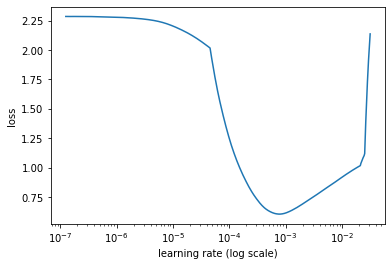

In [19]:
learner.lr_find(show_plot=True,max_epochs=3)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 3)

In [20]:
learner.fit_onecycle(2e-5,5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
276/276 [==============================] - 258s 909ms/step - loss: 1.9234 - accuracy: 0.3648 - val_loss: 0.6299 - val_accuracy: 0.8596
Epoch 2/5
276/276 [==============================] - 250s 901ms/step - loss: 0.5044 - accuracy: 0.8810 - val_loss: 0.3135 - val_accuracy: 0.9176
Epoch 3/5
276/276 [==============================] - 250s 903ms/step - loss: 0.2276 - accuracy: 0.9475 - val_loss: 0.2134 - val_accuracy: 0.9411
Epoch 4/5
276/276 [==============================] - 250s 902ms/step - loss: 0.1125 - accuracy: 0.9775 - val_loss: 0.1630 - val_accuracy: 0.9611
Epoch 5/5
276/276 [==============================] - 250s 901ms/step - loss: 0.0601 - accuracy: 0.9920 - val_loss: 0.1523 - val_accuracy: 0.9656


In [31]:
learner.validate(class_names=trans.get_classes())

                     precision    recall  f1-score   support

          Ethnicity       0.99      0.98      0.99       513
                age       0.77      0.67      0.71        15
         disability       0.83      0.71      0.77        14
             gender       0.95      0.96      0.95       126
physical-appearance       0.86      0.67      0.75         9
         profession       0.99      1.00      0.99       333
           religion       0.91      0.94      0.92        52
 sexual-orientation       1.00      0.75      0.86        12
      socioeconomic       0.74      0.77      0.75        30

           accuracy                           0.97      1104
          macro avg       0.89      0.83      0.86      1104
       weighted avg       0.97      0.97      0.96      1104



array([[505,   0,   0,   0,   0,   2,   3,   0,   3],
       [  1,  10,   0,   0,   0,   0,   2,   0,   2],
       [  0,   1,  10,   1,   0,   1,   0,   0,   1],
       [  2,   0,   0, 121,   0,   1,   0,   0,   2],
       [  0,   1,   1,   1,   6,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 333,   0,   0,   0],
       [  2,   1,   0,   0,   0,   0,  49,   0,   0],
       [  0,   0,   0,   2,   1,   0,   0,   9,   0],
       [  2,   0,   1,   3,   0,   1,   0,   0,  23]])

In [32]:
learner.view_top_losses(n=5, preproc=trans)

----------
id:389 | loss:7.68 | true:gender | pred:Ethnicity)

----------
id:553 | loss:7.1 | true:disability | pred:profession)

----------
id:126 | loss:6.37 | true:socioeconomic | pred:profession)

----------
id:763 | loss:5.98 | true:gender | pred:profession)

----------
id:485 | loss:5.95 | true:religion | pred:Ethnicity)



In [33]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [34]:
predictor = ktrain.get_predictor(learner.model,preproc=trans)

In [36]:
predictor.explain(X_test[389])

In [70]:
predictor.get_classes()

['Ethnicity',
 'age',
 'disability',
 'gender',
 'physical-appearance',
 'profession',
 'religion',
 'sexual-orientation',
 'socioeconomic']

In [87]:
s = dict(zip(predictor.get_classes(),predictor.predict_proba(X_test[389])))

In [91]:
s

{'Ethnicity': 0.9958217,
 'age': 0.00026282208,
 'disability': 0.00023199386,
 'gender': 0.00046335344,
 'physical-appearance': 0.00029827093,
 'profession': 0.0005058299,
 'religion': 0.00084674946,
 'sexual-orientation': 0.00041475834,
 'socioeconomic': 0.0011545819}

In [92]:
predictor.predict("You're pretty for a black girl")

'Ethnicity'

In [95]:
def get_probabilit_per_class(text):
  return dict(zip(predictor.get_classes(),predictor.predict_proba(text)))

In [96]:
get_probabilit_per_class("You're pretty for a black girl")

{'Ethnicity': 0.99647814,
 'age': 0.00023676499,
 'disability': 0.00021296345,
 'gender': 0.00036392428,
 'physical-appearance': 0.00025343779,
 'profession': 0.0005191953,
 'religion': 0.0006858085,
 'sexual-orientation': 0.0003764894,
 'socioeconomic': 0.0008733325}

In [97]:
predictor.explain("You're pretty for a black girl")

In [98]:
predictor.explain('That bitch got 5 million boyfriends')

In [99]:
predictor.explain(X_test[553])

In [100]:
predictor.explain(X_test[763])

In [101]:
get_probabilit_per_class(X_test[763])

{'Ethnicity': 0.0031632928,
 'age': 0.001045222,
 'disability': 0.0011373376,
 'gender': 0.002522685,
 'physical-appearance': 0.0016257138,
 'profession': 0.9747142,
 'religion': 0.001899612,
 'sexual-orientation': 0.0007278537,
 'socioeconomic': 0.0131640965}

In [102]:
predictor.save('/distilbert_Explicit_Categorized')

# Analyzing results - Research

Link : http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf